# Example - Estimate Excess Surface Density with stacking strategy

we import some clmm modules

In [1]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
from numpy import random
from astropy.table import Table

clmm.__version__

'0.3.0'

we import `clmm` module's core.

In [2]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
from clmm import Cosmology 

we import module for mock data

In [3]:
import mock_data as mock

basic modules

In [4]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

we import `DC2Analysis` modules

In [5]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import stacking as st
import modeling as model
import utils as ut
import mcmc as mcmc

for reproductibility :

In [6]:
np.random.seed(11)

we define cosmology into `Cosmology` object

In [7]:
mock_cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

we define the `Modeling` object `moo` to for the galaxy cluster.

In [8]:
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)

we define the `Stacking` object `stack` by definning a given range of radial axis, the number of bins for the binned stacked shear profile.

In [9]:
stack = st.Stacking(r_low = 0.5,  r_up = 5, n_bins = 10, cosmo = mock_cosmo)

we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

In [10]:
deltasigma = True

In [11]:
stack._select_type(is_deltasigma = deltasigma)

We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

In [12]:
z_bin = [0.4,0.5]
m_bin = [10**14, 1.2*10**14]
m_bin = np.array(m_bin)
n_catalogs = 80
ngals = 2000

we define a set of selected cluster with given true masses ans true redshifts

In [13]:
cluster_m = (m_bin[1] - m_bin[0])*np.random.random(n_catalogs) + m_bin[0] #in M_sun
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]
concentration = model.Duffy_concentration(cluster_m, cluster_z, 'mean')

We add each galaxy catalogs that correponds to binning to the `stack` object

In [14]:
x_list = []

for i in range(n_catalogs):
    
    """Generate mock data"""
    
    data = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], concentration[i], mock_cosmo,  200,'chang13', zsrc_min = cluster_z[i] + 0.1 ,shapenoise = 0.4,ngals=ngals)

    mock._compute_photoz_pdfs(data, 0.01)
    
    """Create GalaxyCluster object"""
    
    cl = clmm.GalaxyCluster('cluster', 0, 0, cluster_z[i], data)
    
    """Add tangential and cross components"""
    
    # the critical surface density is recquired then set is_deltasigma = True whatever you estimate reduced shear or deltasigma
    
    cl.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = True, cosmo = stack.cosmo)
    
    """Create profile"""
    
    bin_edges = pa.make_bins( stack.r_low , stack.r_up , stack.n_bins , method='evenlog10width')

    profile = cl.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=stack.cosmo,include_empty_bins= True,gal_ids_in_bins=True)
    
    """Estimate individual shear profile"""
    
    stack._add_background_galaxies(cl, profile)
    
    stack._estimate_individual_lensing_signal(cl, profile)
    
    x_list.append(profile['radius'])
    
    """Add catalog of background galaxies to stack"""
    
    stack._add_cluster_redshift(cl)
    

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/stacking.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask_redshift = np.array([pzbins_ > cl.z for i, pzbins_ in enumerate(cl.galcat['pzbins'])])
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/stacking.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-t

we can see how much catalogs have been selected

In [15]:
print(f'we selected {stack.n_stacked_cluster} clusters')

we selected 80 clusters


The attribute `profile` of `shear` object is filled using the method `MakeShearProfile`. We can comput the standard deviation of every lensing signal derived from individial cluster from the stacked lensing signal via `._add_standard_deviation()`

In [16]:
stack.MakeStackedProfile() 
stack._add_standard_deviation()
stack._reshape_data()

The `profile` attribute of `stack`is an astropy table containing the binned profile `gt` along the radial axis `radius` and the error `gt_err`.

In [17]:
profile = stack.profile

In [18]:
profile

radius,gt,gx,n_gal,gt_err,gx_err
float64,float64,float64,float64,float64,float64
0.5699810728199609,115010569075649.92,22370583624747.426,1142.0,275730543229571.2,263317249656536.7
0.7160556829401523,95051852764714.45,-10019585616564.865,1821.0,213000019050888.78,181643021069415.62
0.8968978318197063,62664048555927.5,9301474678436.467,2843.0,142810345317749.2,163534930052307.53
1.1312531621682604,24657538880551.492,-883318526640.5009,4589.0,119528852364772.55,133650602122534.23
1.4235002528507086,4190442515143.5845,309385812641.1368,7210.0,102691005978043.78,93356709694906.77
1.7931523884061285,27301221656276.117,-4576318988113.722,11573.0,84588961420072.72,76592693523075.2
2.2583626753766275,18755688340352.39,4800857748512.884,18383.0,72246973760998.45,65925644929576.92
2.8440808007161933,1761828308796.25,-56580365465.13845,28794.0,52705452990003.7,50557557088642.82
3.5787682855112815,1869470397559.9343,3855817844211.7856,45440.0,37969658540949.66,40520443383326.42


### Visualization of the results

we visualize the reduced tangential stacked shear and we calculate the predicted reduced shear when using the average innput mass of selected clusters. The sum above is aver all lense-source pairs. We also visualize individual shear profiles estimated only by summation over the background galaxies itself.

$$\Delta \Sigma(R) = \left(\frac{1}{\sum\limits_{l,s} w_{l,s}}\right)\sum\limits_{l,s} w_{l,s}\Sigma_c(z_s,z_l)e^t_{l,s}  \ at\ R$$

with : 
    $$
    w_{l,s} = \left \langle \frac{1}{\Sigma_c(z_s,z_l)^2} \right \rangle \times \frac{1}{\sigma_{SN}^2 + \sigma_e^2}
    $$

the list of galaxy redshift is given by:

In [19]:
z_gal = sum(stack.z_galaxy, [])

we plot the results for the estimated stacked shear signal (in red) relatively to individual estimated shear signal from all the selected cluster

In [20]:
def myticks(x,pos):

    if x == 0: return "$0$"

    exponent = int(np.log10(abs(x)))
    sign = x/abs(x)
    coeff = x/(10**exponent)

    return r"${:2.0f}.10^{{ {:2d} }}$".format(coeff,exponent)

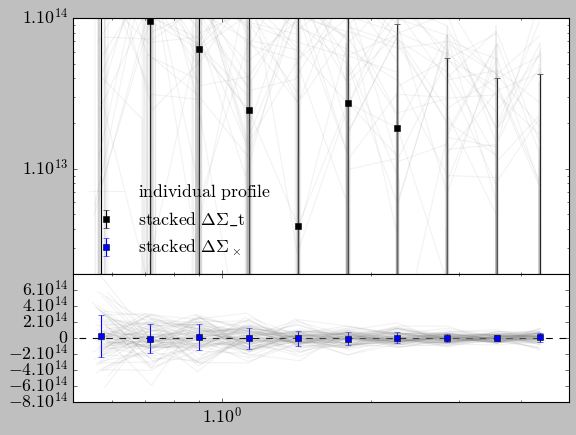

In [21]:
from matplotlib import gridspec
import matplotlib.ticker as ticker

# Simple data to display in various forms
r = profile['radius']
rr = np.logspace(-2,7,100)
gt, gt_err = profile['gt'], profile['gt_err']
gx, gx_err = profile['gx'], profile['gx_err']


fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
ax0 = plt.subplot(gs[0])
ax0.tick_params(axis='both', which='major', labelsize=16)
#ax0.set_ylabel('r'$\rm{stacked}\ \Delta\Sigma_\times$)

# log scale for axis Y of the first subplot
ax0.set_yscale("log")
ax0.set_xscale("log")
ax0.set_xlim(stack.r_low, stack.r_up)
ax0.set_ylim(2*10**12, 10**14)
line0 = ax0.errorbar(r, gt,gt_err, c='k', fmt = 's',  label=r'$\rm{stacked}\ \Delta\Sigma\_t$')
ax0.plot(r, gt , '-', c = 'grey',alpha = 0.1, label = r'$\rm{individual\ profile}$')
ax0.errorbar([],[],[], c='b', fmt = 's', label=r'$\rm{stacked}\ \Delta\Sigma_\times$')

for i in range(stack.n_stacked_cluster):
    
    ax0.plot(x_list[i],stack.LS_t_list[i],'-',c='grey',alpha=0.1)
    
ax0.yaxis.set_major_formatter(ticker.FuncFormatter(myticks))
ax0.legend(loc='best', frameon = False,
          numpoints = 1, fontsize = 16)

##############################
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.tick_params(axis='both', which='major', labelsize=16)



line1 = ax1.errorbar(r, gx,gx_err, c='b', fmt = 's', label=r'$\Delta\Sigma_\times$')
ax1.plot(rr, 0*rr, '--k')

for i in range(stack.n_stacked_cluster):
    
    ax1.plot(x_list[i],stack.LS_x_list[i],c='grey',alpha=0.1)

plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot

yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(myticks))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(myticks))

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

# Fitting join Halo mass and halo concentration with MCMC

We first estimate halo mass and concentration with `scipy.optimize.curve_fit` function to initialize the walkers positions for MCMC analysis

## Fitting Halo Mass and concentration using `curve_fit` from `scipy.optimize`


In [22]:
def model_data(r, logm, c):
    
    cluster_z = stack.z_average
    
    z_gal_per_bin = stack.z_galaxy
    
    z_gal = sum(z_gal_per_bin, [])

    if stack.is_deltasigma == False:

        return model.predict_reduced_tangential_shear_z_distrib(r, logm, c, cluster_z , z_gal_per_bin, moo)

    else:

        return model.predict_excess_surface_density(r, logm, c, stack.z_average, moo)

In [23]:
r, gt, gt_err = profile['radius'], profile['gt'], profile['gt_err']

In [24]:
param_p0 = [14.,2.]
            
param_bounds = ([13., 0. ], [16., 20.])

popt_fit, cov_fit = curve_fit(model_data, r, gt, sigma = gt_err, bounds = param_bounds, p0 = param_p0)

In [25]:
m = 10**popt_fit[0]
err_m = m*np.log(10)*np.sqrt(cov_fit[0][0])
c = popt_fit[1]
err_c = np.sqrt(cov_fit[1][1])

In [26]:
print(r'$---> Average input mass M_{200m}^{NFW}$' + f' : {np.mean(cluster_m):2e}' + r'$M_{SUN}$')
print(' ')
print(r'$---> Average input concentration c(M_{200m}^{NFW})$' + f' : {np.mean(concentration):2f}' + r'$M_{SUN}$')
print(' ')
print(f'$---> Average fit mass : {m:2e} \pm {err_m:2e}$')
print(' ')
print(f'$---> Average fit c : {c:2e} \pm {err_c:2f}$')

$---> Average input mass M_{200m}^{NFW}$ : 1.098525e+14$M_{SUN}$
 
$---> Average input concentration c(M_{200m}^{NFW})$ : 5.163357$M_{SUN}$
 
$---> Average fit mass : 1.581375e+14 \pm 4.860204e+13$
 
$---> Average fit c : 2.000000e+01 \pm 47.752144$


# Fitting Halo Mass Using MCMC

we initialize MCMC object

No handles with labels found to put in legend.


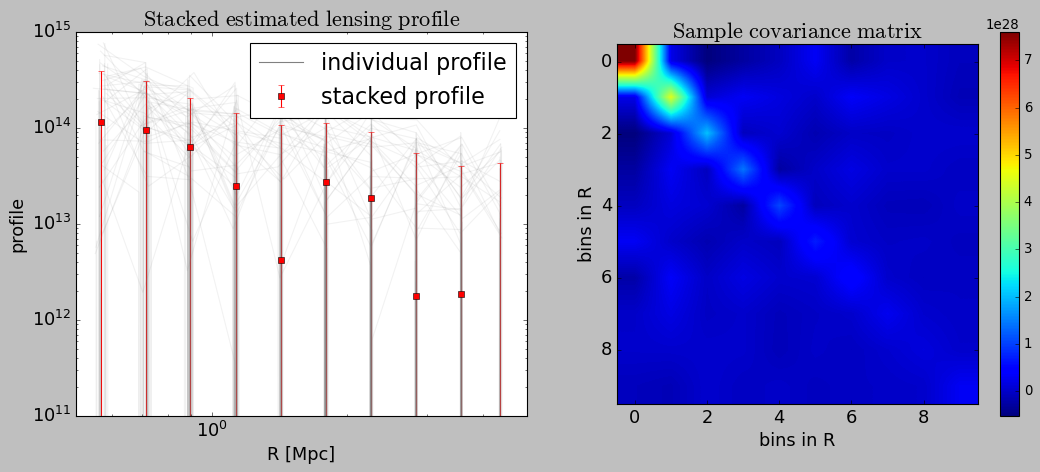

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

for i in range(stack.n_stacked_cluster):
    
    axes[0].plot(x_list[i],stack.LS_t_list[i],c='grey',alpha=0.1)
    
axes[0].plot([],[],c='grey', label='individual profile')    
axes[0].errorbar(profile['radius'], profile['gt'], profile['gt_err'], c='r', fmt = 's', label='stacked profile')
axes[0].set_xlabel('R [Mpc]', fontsize=16)
axes[0].set_ylabel('profile', fontsize=16)
axes[0].legend(fontsize=20, frameon=True, numpoints = 1, loc = 'best')
axes[0].semilogx()
axes[0].semilogy()
axes[0].set_xlim(stack.r_low, stack.r_up)
axes[0].set_title(r'$\rm{Stacked\ estimated\ lensing\ profile}$', fontsize = 20)


im1 = axes[1].imshow(stack.cov_t)
fig.colorbar(im1)
axes[1].set_xlabel('bins in R', fontsize=16)
axes[1].set_ylabel('bins in R', fontsize=16)

axes[1].set_title(r'$\rm{Sample\ covariance\ matrix}$', fontsize = 20)
axes[1].legend(fontsize = 20, frameon = False)
plt.show()

In [28]:
MCMC = mcmc.MCMC(n_parameters = 2)

In [29]:
t = Table()
t['x0'] = r
t['y'] = gt

In [30]:
def model_MCMC(X, p):
    
    r = X[0]
    
    logm, c = p[0], p[1]
    
    return model_data(r, logm, c)

we add new attributes with MCMC informations

In [31]:
MCMC._set_data(t)
MCMC._set_covariance_matrix(stack.cov_t)
MCMC._set_model(model_MCMC)
MCMC._set_lnprior_bounds(bounds = [[13., 0. ], [16., 20.]])

In [32]:
MCMC._set_walkers(n_walkers = 300, n_step = 5000)
MCMC._set_initial_condition(popt_fit, np.sqrt(cov_fit.diagonal()))

we start the MCMC

In [33]:
MCMC.run_MCMC()

  0%|          | 0/5000 [00:00<?, ?it/s]/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:31<00:00, 158.35it/s]


In [34]:
MCMC._discard(tau = 50)

In [35]:
dict_ranges = {r'$\log_{10}\ (M/M_\odot)$': (13.75, 14.2), r'$c$': (4.5, 5.1)}

In [36]:
use_params = [r'$\log_{10}\ (M/M_\odot)$', r'$c$']
use_ranges = [[13.75, 14.25], [3, 10]]
true_values = [np.mean(np.log10(cluster_m)), np.mean(concentration)]

<Figure size 640x480 with 0 Axes>

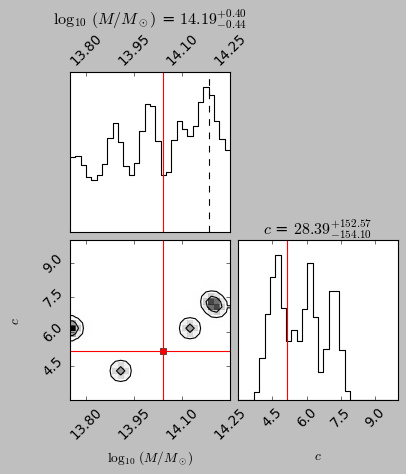

In [37]:
from corner import corner
fig = plt.figure()
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
fig = corner(MCMC.samples\
             ,reverse = False,\
            bins = 30,\
             smooth = True,\
             plot_datapoints=False,levels=(sigma1, sigma2), \
             labels =use_params,\
             quantiles=[0.16, 0.5, 0.84], \
             color='k',\
             range = use_ranges,\
         show_titles = True, \
        truths =true_values, truth_color='r', smooth1d = 1, top_ticks = True)
#plt.savefig('M_to_c_mock.png', bbox_inches='tight', dpi=300)

In [38]:
r = profile['radius']
MCMC.fit_MCMC()
p = MCMC.mean_MCMC
y_fit = model_MCMC([r], p)

we finally plot the results

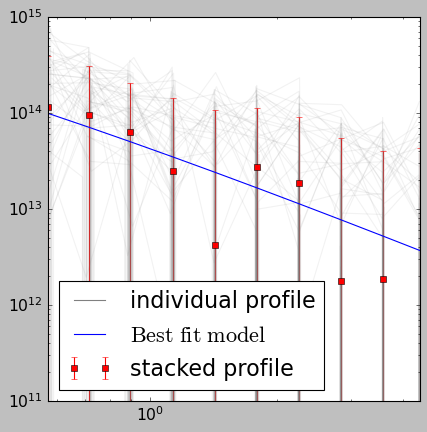

In [39]:
f, ax = plt.subplots(figsize = (6,6))
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.grid(True, ls = '--')
plt.style.use('classic')

for i in range(stack.n_stacked_cluster):
    
    plt.plot(x_list[i],stack.LS_t_list[i],c='grey',alpha=0.1)

plt.plot([],[],c='grey', label='individual profile')  
plt.errorbar(profile['radius'], profile['gt'], profile['gt_err'], c='r', fmt = 's', label='stacked profile')
plt.plot(r,y_fit, label=r'$\rm{Best\ fit\ model}$')
ax.set_xlim(min(r), max(r))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best', fontsize = 20)

In [40]:
data = mock.generate_galaxy_catalog(10**14, 0.4, 4, mock_cosmo,  200,'chang13', zsrc_min = cluster_z[i] + 0.01 ,shapenoise = 0.05,ngals=ngals)

mock._compute_photoz_pdfs(data, 0.01)
    
"""Create GalaxyCluster object"""
    
cl = clmm.GalaxyCluster('cluster', 0, 0, 0.4, data)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [41]:
mask_redshift = np.array([pzbins_ > cl.z for i, pzbins_ in enumerate(cl.galcat['pzbins'])])

mask_last_item = np.array([ (pzbins_ != pzbins_[-1]) for i, pzbins_ in enumerate(cl.galcat['pzbins'])])

mask = mask_redshift * mask_last_item

pzbins = np.array([pzbins_[mask[i]] for i, pzbins_ in enumerate(cl.galcat['pzbins'])])

pzbins_le = np.array([pzbins_[mask_redshift[i]] for i, pzbins_ in enumerate(cl.galcat['pzbins'])])

dz = np.array([np.array(pzbins_[1:len(pzbins_):1] - pzbins_[0:len(pzbins_) - 1:1])  for i, pzbins_ in enumerate(pzbins_le)]) 

pdf = np.array([pzpdf_[mask[i]] for i, pzpdf_ in enumerate(cl.galcat['pzpdf'])])

cl.galcat['sigma_c_pdf'] = model.critical_surface_density(cl.z, pzbins ,mock_cosmo)

norm_pdf = np.array([np.sum(pdf_*dz[i])  for i, pdf_ in enumerate(pdf)])

critical_density_2 = np.array([np.sum(sigma_c**(-2.)*pdf[i]*dz[i]/norm_pdf[i]) \
                               for i, sigma_c in enumerate(cl.galcat['sigma_c_pdf'])])
print(1)


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged 

1


/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling.py:218: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(sigma_c)


In [42]:
a = np.array([1,2,3])

In [43]:
a[0:len(a) - 1:1]

array([1, 2])

In [44]:
dz = np.array([pzbins_[1:len(pzbins_):1] - pzbins_[0:len(pzbins_) - 1:1]  for i, pzbins_ in enumerate(cl.galcat['pzbins'])]) 

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [45]:
dz

array([array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03]),
       array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]),
       array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]),
       ...,
       array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03]),
       array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03]),
       array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])],
      dtype=object)